# <font color='#42AAFF'>Содержание</font><a id='toc0_'></a>  <a id='toc0_'></a>    
1. [<font color='#42AAFF'>Импорт и обзор данных</font>](#toc1_)    
1.1. [<font color='#42AAFF'>Вывод</font>](#toc1_1_)    
2. [<font color='#42AAFF'>Обзор данных</font>](#toc2_)    
2.1. [<font color='#42AAFF'>Вывод</font>](#toc2_1_)    
3. [<font color='#42AAFF'>Предобработка данных</font>](#toc3_)    
3.1. [<font color='#42AAFF'>Вывод</font>](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
from tqdm.notebook import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.stats.stattools import medcouple
import seaborn as sns

# 1. <a id='toc1_'></a>[<font color='#42AAFF'>Импорт и обзор данных</font>](#toc0_)

Импортируем базовую выборку товаров (https://disk.yandex.ru/d/BBEphK0EHSJ5Jw), она достаточно большая - содержит почти 3 млн. строк и 72 столбца - признака в численном виде, и не содержит информации о наиболее близких объектах.

Структура входных данных:
- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

In [2]:
features_base = pd.read_csv("data/base.csv", index_col=0)
features_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [3]:
features_base.shape

(2918139, 72)

In [4]:
features_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


Тренировочная выборка имеет 100 тыс. строк и 73 столбца - 72 столбца признаков и 1 столбец с наилучшей рекомендацией с точки зрения экспертов. Данные также представлены в float64. Разделим целевой и остальные признаки.

In [5]:
features_train = pd.read_csv("data/train.csv", index_col=0)
target_train = features_train[["Target"]].copy()
features_train.drop("Target", axis=1, inplace=True)
features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


In [6]:
features_train.shape

(100000, 72)

In [7]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [8]:
features_test = pd.read_csv("data/validation.csv", index_col=0)
features_test.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [9]:
features_test.shape

(100000, 72)

In [10]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [11]:
target_test = pd.read_csv("data/validation_answer.csv")
target_test = target_test.set_index('Id')
target_test = target_test.rename({'Expected':'Target'},axis = 1)
target_test.head()

,Target
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Проверим наличие пропусков:

In [12]:
features_base.isna().sum().sum(), features_train.isna().sum().sum(), features_test.isna().sum().sum(), target_train.isna().sum().sum(), target_test.isna().sum().sum()

(0, 0, 0, 0, 0)

Проверим наличие дубликатов:

In [13]:
features_base.duplicated().sum(),features_train.duplicated().sum(),features_test.duplicated().sum()

(0, 0, 0)

## 1.1. <a id='toc1_1_'></a>[<font color='#42AAFF'>Вывод</font>](#toc0_)

1. Базовая выборка содержит 3 млн строк и 72 столбца в формате float64 и занимает объем памяти в 1.6 Гб.
2. В тренировочной и тестовой выборках представлены по 100 тыс. строк, соответствующих рассматриваемым товарам, и каждому из их поставлен в соответствие ближайший сосед из базовой выборки. Данные также представлены во float64.
3. Пропуски отсутствуют.
4. Дубликаты отсутствуют.

# 2. <a id='toc2_'></a>[<font color='#42AAFF'>Обзор данных</font>](#toc0_)

Рассмотрим основные параметры распределений признаков. В большей степени нас будут интересовать характеристики скошенности и крутизны распределений, по которым можно определить степень близости к нормальному распределению, также IQR и доля выбросов вне диапазона [median-1.5 IQR; median+1.5 IQR]

In [14]:
%%time
pd.set_option('display.max_columns', None)
pd.set_option('display.width', -1)
df_agg = features_base.agg(
    ['count','mean','std',np.var,'min',lambda x: x.quantile(0.1),lambda x: x.quantile(0.25),lambda x: x.quantile(0.5),
    lambda x: x.quantile(0.75),lambda x: x.quantile(0.9),'max', lambda x: x.skew(), lambda x: x.kurtosis(), lambda x: x.quantile(0.75)-x.quantile(0.25),
    lambda x: len(x[(x>2.5*x.quantile(0.75)-1.5*x.quantile(0.25))|(x<2.5*x.quantile(0.25)-1.5*x.quantile(0.75))])/len(x)*100,
    lambda x:len(x.unique())/len(x)*100])
df_agg.index=['count', 'mean', 'std', 'var', 'min', '10%', '25%', '50%','75%', '90%', 'max','skewness','kurtosis','IQR','IQR_outliers_ratio','unique_values_ratio']
df_agg = df_agg.applymap('{:.1f}'.format).astype('float').T
df_agg.T

Wall time: 2min 2s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0,2918139.0
mean,-86.2,8.1,-44.6,-146.6,111.3,-72.0,-392.2,20.4,123.7,124.5,-143.1,-69.9,-41.3,7.6,149.0,-23.2,-0.9,-19.3,-137.3,-79.2,-98.3,1257.5,-6.8,56.7,26.7,727.1,-66.3,16.3,-86.4,151.7,-11.6,-144.2,87.2,-554.2,36.2,75.2,-16.5,-146.6,-118.5,-41.9,-9.5,4.1,-112.7,120.9,-39.8,58.9,-84.9,-138.5,47.9,-32.4,26.6,-21.7,67.0,-117.9,88.0,69.2,-132.9,13.2,-119.6,-316.1,-64.9,-130.7,-79.0,33.3,-154.8,14.2,67.8,23.5,75.0,115.6,-799.3,-47.8
std,24.9,5.0,38.6,19.8,46.3,28.2,271.7,64.2,6.4,64.4,41.7,51.2,39.0,36.6,33.6,13.1,20.8,53.0,46.6,0.8,28.2,400.0,52.0,34.4,38.9,205.6,61.5,4.7,48.5,10.1,29.0,34.8,27.9,260.6,39.9,21.4,25.9,10.0,13.1,19.2,8.2,5.8,56.9,46.7,14.7,32.1,63.2,57.7,45.2,58.3,59.0,51.7,13.1,54.7,4.8,11.9,7.8,51.1,55.2,210.7,62.5,9.6,30.5,28.9,41.2,99.0,1.8,55.3,61.3,21.2,385.4,41.7
var,619.6,24.5,1492.4,393.8,2148.1,794.5,73796.4,4123.7,40.4,4151.3,1737.8,2623.5,1518.2,1339.4,1131.4,171.0,434.0,2806.0,2174.0,0.6,792.9,159969.0,2701.1,1180.7,1516.4,42260.0,3786.4,21.7,2353.5,101.8,838.1,1208.1,775.9,67937.7,1591.6,460.0,668.5,99.1,172.8,368.5,67.1,34.1,3242.2,2182.8,217.4,1031.1,3993.4,3333.7,2043.2,3397.4,3475.4,2676.9,170.9,2992.7,22.8,142.8,61.1,2609.2,3051.8,44379.5,3904.0,91.6,927.6,834.4,1699.9,9791.3,3.3,3062.8,3763.2,448.4,148543.2,1742.9
min,-199.5,-13.9,-240.1,-232.7,-105.6,-211.0,-791.5,-301.9,93.2,-173.9,-343.8,-368.5,-226.1,-175.6,-15.3,-85.9,-96.4,-272.6,-351.7,-83.2,-243.7,136.8,-238.3,-88.2,-143.2,-62.0,-358.6,-8.4,-314.0,107.4,-156.7,-298.7,-34.7,-1045.3,-137.9,-21.5,-138.0,-195.4,-176.9,-132.7,-47.6,-21.6,-338.1,-87.7,-63.1,-77.2,-362.9,-418.7,-145.4,-322.8,-280.3,-264.6,6.2,-381.3,65.6,14.1,-167.1,-196.2,-359.7,-681.0,-400.8,-171.3,-220.6,-88.5,-353.9,-157.6,59.5,-233.1,-203.6,15.7,-1297.9,-226.8
10%,-118.2,1.7,-94.4,-172.2,51.7,-108.4,-759.6,-61.1,115.4,42.9,-198.3,-135.3,-92.1,-39.6,105.6,-40.0,-27.8,-86.5,-196.7,-80.2,-135.2,519.1,-74.1,12.4,-24.2,366.8,-144.9,10.4,-149.4,139.0,-48.9,-188.8,52.0,-945.0,-14.3,48.4,-49.9,-159.3,-135.3,-66.4,-19.9,-3.5,-187.4,62.2,-61.1,17.0,-165.8,-212.9,-10.1,-109.7,-49.8,-87.4,50.3,-187.8,82.0,54.0,-143.0,-53.8,-190.4,-608.2,-146.4,-142.9,-118.3,-0.3,-208.3,-123.1,65.4,-46.9,-3.4,88.3,-1074.5,-100.0
25%,-103.1,4.7,-69.6,-159.9,80.5,-91.4,-629.3,-22.2,119.5,81.8,-170.3,-104.0,-66.6,-16.9,126.0,-31.8,-15.2,-55.5,-167.6,-79.7,-116.8,1088.6,-42.2,33.3,0.6,813.8,-107.9,13.3,-118.7,144.9,-30.8,-167.0,68.3,-771.3,9.3,60.9,-34.1,-153.3,-127.4,-54.8,-15.0,0.0,-151.6,88.2,-52.9,37.0,-128.2,-176.6,17.9,-69.9,-12.3,-56.3,58.5,-154.5,84.7,61.3,-138.1,-22.4,-157.4,-498.5,-106.6,-137.4,-98.8,17.0,-180.8,-71.3,66.6,-12.5,33.8,101.7,-1074.5,-75.7
50%,-86.2,8.0,-43.8,-146.8,111.9,-71.9,-422.2,20.8,123.9,123.5,-141.7,-70.2,-40.4,8.1,149.3,-22.9,-1.0,-19.8,-136.8,-79.2,-97.5,1507.2,-6.4,57.0,27.1,813.8,-66.2,16.4,-85.5,151.6,-11.2,-144.1,86.9,-529.3,35.3,74.6,-16.3,-146.7,-118.6,-42.0,-9.5,4.1,-113.1,119.9,-40.0,59.0,-85.1,-137.4,47.0,-29.2,27.5,-22.2,67.2,-117.6,88.0,69.4,-132.8,13.1,-120.5,-316.0,-63.7,-130.9,-78.5,34.7,-154.0,13.8,67.8,23.4,74.9,116.0,-1074.5,-48.6
75%,-69.3,11.5,

Выделим признаки, имеющие значительные отклонения от нормального распределения:

In [15]:
cols1 = df_agg.query(f'abs(skewness)>0.5 | abs(kurtosis)>0.5').index.tolist()
#df_agg.query(f'abs(skewness)>=0.5 | abs(kurtosis)>=0.5 | unique_values_ratio<50')
cols1

['6', '21', '25', '33', '44', '59', '63', '65', '70']

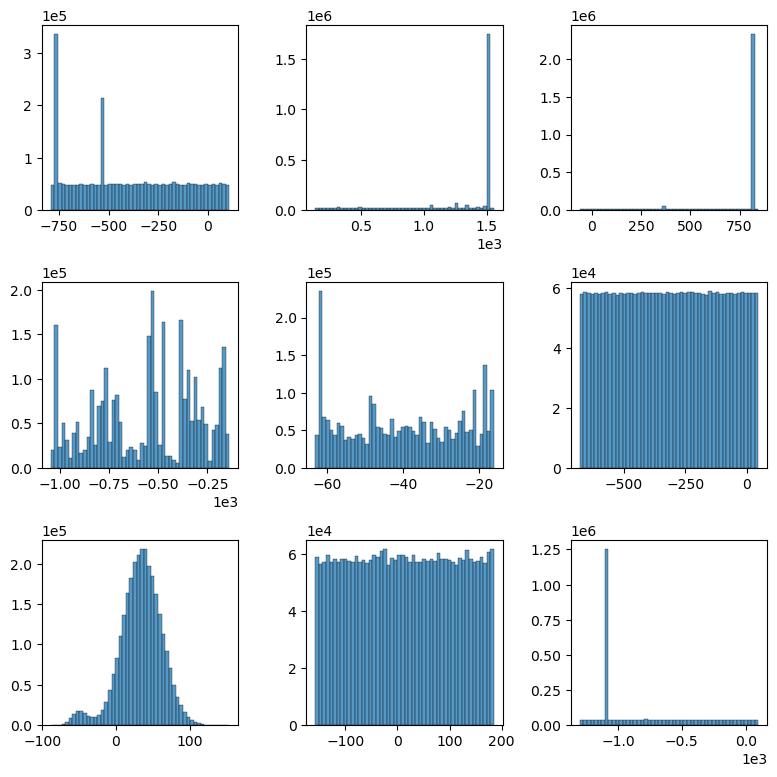

In [16]:
cm = 1/2.54
fig, axs = plt.subplots(3,3,figsize=(20*cm,20*cm),dpi=100)
cmap = plt.cm.get_cmap('tab10')
for ax, col in zip(axs.flat, cols1):
    sns.histplot(features_base[col], ax=ax, bins = 50)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,3))
fig.tight_layout()
plt.show()     

Как видно из графиков 63 признак унимодален, но имеет относительно большой хвост слева, поэтому исключим его из числа признаков не для стандартизации.


In [17]:
cols1.remove('63')
cols1

['6', '21', '25', '33', '44', '59', '65', '70']

In [18]:
cols2 = []
cols2 = [col for col in features_base.columns.tolist() if col not in cols1]

## 2.1. <a id='toc2_1_'></a>[<font color='#42AAFF'>Вывод</font>](#toc0_)

1. Признаки ненормированы, имеют разные масштабы.
2. Большая часть признаков (64) имеет распределения близкие к нормальным. При этом доля выбросов (точки вне диапазона [median-1.5 IQR; median+1.5 IQR]) составляет ~ 1%, и их отклонения не так значительны.
3. Меньшая часть признаков (8) имеет или приблизительно равномерные распределения, или распределения с сильновыраженным пиком. Возможно эти признаки исходно имели дискретный характер. 

# 3. <a id='toc3_'></a>[<font color='#42AAFF'>Предобработка данных</font>](#toc0_)

Cтандартизируем признаки с близким к нормальному распределению, и масштабируем остальные признаки в интервал [-1.96 1.96]. При такой предобработке, признаки будут иметь примерно одинаковое влияние на расстояние. 

Переводить признаки из кажущегося избыточным формата float64 в float32/float16 большого смысла нет, это не дает существенного прироста в производительности, памяти достаточно для обработки.

In [19]:
scaler = StandardScaler()
scaler.fit(features_base[cols2])
features_base[cols2] = scaler.transform(features_base[cols2])
features_train[cols2] = scaler.transform(features_train[cols2])
features_test[cols2] = scaler.transform(features_test[cols2])

In [20]:
scaler = MinMaxScaler((-1.96,1.96))
scaler.fit(features_base[cols1])
features_base[cols1] = scaler.transform(features_base[cols1]) 
features_train[cols1] = scaler.transform(features_train[cols1]) 
features_test[cols1] = scaler.transform(features_test[cols1]) 

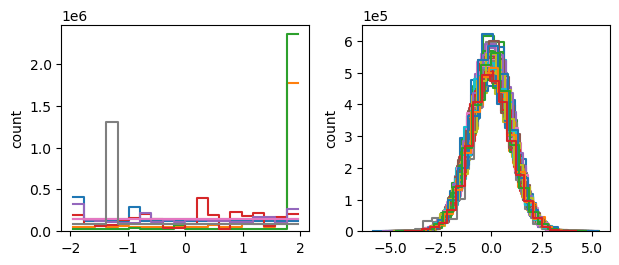

In [21]:
cm = 1/2.54
fig, axs = plt.subplots(1,2,figsize=(16*cm,7*cm),dpi=100)
cmap = plt.cm.get_cmap('tab10')
for col in cols1:    
    sns.histplot(features_base[col], element="step", fill=False, bins = 20, ax = axs[0])
for col in cols2:    
    sns.histplot(features_base[col], element="step", fill=False, bins = 20, ax = axs[1])    

for ax in axs:
    ax.set_xlabel(None)
    ax.set_ylabel('count')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,3))    

fig.tight_layout()
plt.show()  

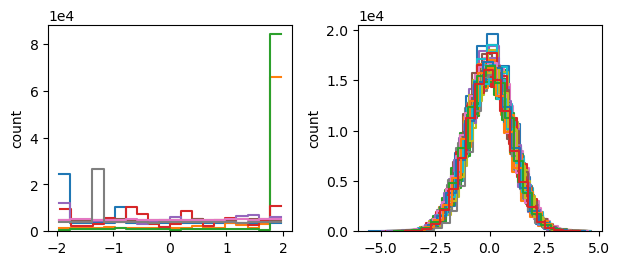

In [22]:
cm = 1/2.54
fig, axs = plt.subplots(1,2,figsize=(16*cm,7*cm),dpi=100)
cmap = plt.cm.get_cmap('tab10')
for col in cols1:    
    sns.histplot(features_train[col], element="step", fill=False, bins = 20, ax = axs[0])
for col in cols2:    
    sns.histplot(features_train[col], element="step", fill=False, bins = 20, ax = axs[1])    

for ax in axs:
    ax.set_xlabel(None)
    ax.set_ylabel('count')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,3))    

fig.tight_layout()
plt.show()  

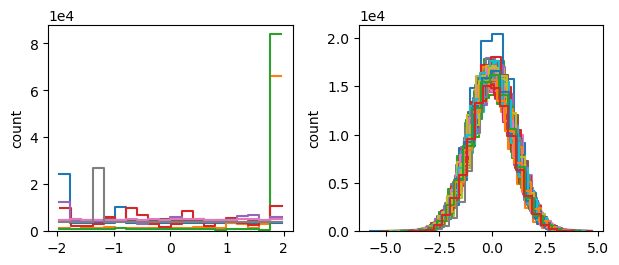

In [23]:
cm = 1/2.54
fig, axs = plt.subplots(1,2,figsize=(16*cm,7*cm),dpi=100)
cmap = plt.cm.get_cmap('tab10')
for col in cols1:    
    sns.histplot(features_test[col], element="step", fill=False, bins = 20, ax = axs[0])
for col in cols2:    
    sns.histplot(features_test[col], element="step", fill=False, bins = 20, ax = axs[1])    

for ax in axs:
    ax.set_xlabel(None)
    ax.set_ylabel('count')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,3))    

fig.tight_layout()
plt.show()  

Сохраним преобразованные признаки в xls файлы:

In [24]:
features_base.to_csv('features_base.csv',float_format='%f')

In [25]:
features_train.to_csv('features_train.csv',float_format='%f')
features_test.to_csv('features_test.csv',float_format='%f')
target_train.to_csv('target_train.csv',float_format='%f')
target_test.to_csv('target_test.csv',float_format='%f')

In [26]:
features_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.557490,0.373663,-0.435627,0.884544,0.457647,0.730739,-0.414634,0.782016,1.002855,-0.375101,-0.205102,0.331891,0.990428,-0.366172,-0.201901,1.821474,-0.495776,-0.153067,-2.018434,1.821481,0.401357,-1.695555,-0.898763,-0.294308,0.053139,0.035324,-0.264625,0.234490,-0.838855,1.693444,0.802346,-0.672953,-0.389062,0.113107,-0.401239,-1.408690,-0.706407,-0.962196,-1.490687,-1.297786,-0.221262,0.006961,0.952905,-2.373083,-1.299418,1.575435,0.849891,0.521368,0.289868,0.887738,0.434020,-1.133244,0.708819,1.725900,0.006792,-0.847513,1.189049,0.190524,0.073589,-1.008229,-2.262493,-0.510438,0.293004,-0.014051,1.366325,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.112971,-0.871900,-0.623903,1.098487,0.044024,-1.110550,-0.708061,0.019863,-0.175511,2.443115,0.772555,1.275379,-2.309537,-1.439194,0.584751,-1.151335,0.017071,0.391985,1.024130,1.821481,1.128945,0.182305,0.967912,-0.354679,0.139135,-0.867072,0.502760,1.241820,-0.484388,-1.016663,1.931513,-0.191941,0.621727,0.448081,0.096886,1.644973,0.377855,-1.764135,0.635641,0.110433,-1.291030,-0.875347,-2.315388,0.040403,0.552763,-0.676365,-0.264252,-0.062545,1.968427,0.471024,-0.751284,0.893917,0.868963,0.344869,1.221724,-1.871023,-1.272135,0.270119,-0.073569,-1.237666,0.225102,0.014491,1.711283,0.059848,1.444539,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.711699,0.654489,0.828686,0.619635,0.055584,0.925419,-0.266969,-0.138427,-0.249727,0.086250,-0.297232,0.266713,0.548177,0.211300,0.561152,1.821474,0.123218,0.798420,0.941125,1.821481,-0.633115,0.543167,-0.173451,-0.034379,-0.341126,-0.017624,-1.389921,-0.816119,0.715076,0.213659,0.119768,-0.343543,-0.018741,0.051189,-0.700836,-1.012893,0.332335,-0.473378,-0.597194,0.217647,1.180543,0.227719,-0.594647,0.167182,0.718063,-0.641396,-0.050595,-0.457544,-1.046686,0.064866,1.173565,1.019862,0.100690,-1.145432,-0.586374,-0.417020,0.086191,0.440159,-1.269686,1.299150,-1.220546,0.773022,0.099669,0.048521,-1.332816,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.183859,-0.840347,-0.259958,0.182763,0.831647,-0.676517,-1.055436,-2.392927,-1.052125,-1.210563,-0.184844,0.521802,0.266280,0.106011,-0.344102,1.744044,-2.279026,-0.931804,-1.120055,1.821481,-1.892094,-0.343526,0.483212,-0.052786,0.767553,0.267525,-1.021062,0.268559,0.186153,0.820955,-0.868315,0.160416,-0.440011,0.260575,-1.008532,1.111355,-0.207940,0.022450,1.854296,1.441234,-0.150187,1.293774,-0.413926,0.102224,-0.351370,1.657912,-0.266495,0.103088,-1.487460,0.287182,-0.564120,-0.104031,1.039236,-1.204111,-0.394438,-1.949926,0.274980,-1.372853,0.184217,-0.588466,-0.871349,-0.797073,1.014714,0.090076,-1.332816,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.247061,0.386656,-0.238677,-0.191508,0.786741,0.603370,-0.230059,-0.936647,-0.407671,1.197411,0.473353,2.470925,0.138079,-0.167054,1.435081,1.147328,0.501243,0.091325,1.270212,-0.342139,-0.170210,1.070420,1.284306,1.551134,-1.120939,-0.112179,0.388527,-0.285235,1.507050,-0.192924,-0.776529,1.132181,-0.395369,-0.149007,-0.167623,0.737548,-0.976193,2.034737,0.550034,0.246840,1.831324,-1.265556,0.216093,-0.608032,-0.949457,-0.239793,-0.939913,1.679265,0.554160,-0.930411,-0.240105,1.260652,-1.032096,-1.147395,-0.570116,0.559135,0.716557,0.808178,-0.110496,0.825802,-0.562342,-0.470720,-0.157210,0.920175,-1.332816,1.152406


In [28]:
features_base = pd.read_csv('features_base.csv',index_col=0)
features_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.557490,0.373663,-0.435627,0.884544,0.457647,0.730739,-0.414634,0.782016,1.002855,-0.375101,-0.205102,0.331891,0.990428,-0.366172,-0.201901,1.821474,-0.495776,-0.153067,-2.018434,1.821481,0.401357,-1.695555,-0.898763,-0.294308,0.053139,0.035324,-0.264625,0.234490,-0.838855,1.693444,0.802346,-0.672953,-0.389062,0.113107,-0.401239,-1.408690,-0.706407,-0.962196,-1.490687,-1.297786,-0.221262,0.006961,0.952905,-2.373083,-1.299418,1.575435,0.849891,0.521368,0.289868,0.887738,0.434020,-1.133244,0.708819,1.725900,0.006792,-0.847513,1.189049,0.190524,0.073589,-1.008229,-2.262493,-0.510438,0.293004,-0.014051,1.366325,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.112971,-0.871900,-0.623903,1.098487,0.044024,-1.110550,-0.708061,0.019863,-0.175511,2.443115,0.772555,1.275379,-2.309537,-1.439194,0.584751,-1.151335,0.017071,0.391985,1.024130,1.821481,1.128945,0.182305,0.967912,-0.354679,0.139135,-0.867072,0.502760,1.241820,-0.484388,-1.016663,1.931513,-0.191941,0.621727,0.448081,0.096886,1.644973,0.377855,-1.764135,0.635641,0.110433,-1.291030,-0.875347,-2.315388,0.040403,0.552763,-0.676365,-0.264252,-0.062545,1.968427,0.471024,-0.751284,0.893917,0.868963,0.344869,1.221724,-1.871023,-1.272135,0.270119,-0.073569,-1.237666,0.225102,0.014491,1.711283,0.059848,1.444539,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.711699,0.654489,0.828686,0.619635,0.055584,0.925419,-0.266969,-0.138427,-0.249727,0.086250,-0.297232,0.266713,0.548177,0.211300,0.561152,1.821474,0.123218,0.798420,0.941125,1.821481,-0.633115,0.543167,-0.173451,-0.034379,-0.341126,-0.017624,-1.389921,-0.816119,0.715076,0.213659,0.119768,-0.343543,-0.018741,0.051189,-0.700836,-1.012893,0.332335,-0.473378,-0.597194,0.217647,1.180543,0.227719,-0.594647,0.167182,0.718063,-0.641396,-0.050595,-0.457544,-1.046686,0.064866,1.173565,1.019862,0.100690,-1.145432,-0.586374,-0.417020,0.086191,0.440159,-1.269686,1.299150,-1.220546,0.773022,0.099669,0.048521,-1.332816,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.183859,-0.840347,-0.259958,0.182763,0.831647,-0.676517,-1.055436,-2.392927,-1.052125,-1.210563,-0.184844,0.521802,0.266280,0.106011,-0.344102,1.744044,-2.279026,-0.931804,-1.120055,1.821481,-1.892094,-0.343526,0.483212,-0.052786,0.767553,0.267525,-1.021062,0.268559,0.186153,0.820955,-0.868315,0.160416,-0.440011,0.260575,-1.008532,1.111355,-0.207940,0.022450,1.854296,1.441234,-0.150187,1.293774,-0.413926,0.102224,-0.351370,1.657912,-0.266495,0.103088,-1.487460,0.287182,-0.564120,-0.104031,1.039236,-1.204111,-0.394438,-1.949926,0.274980,-1.372853,0.184217,-0.588466,-0.871349,-0.797073,1.014714,0.090076,-1.332816,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.247061,0.386656,-0.238677,-0.191508,0.786741,0.603370,-0.230059,-0.936647,-0.407671,1.197411,0.473353,2.470925,0.138079,-0.167054,1.435081,1.147328,0.501243,0.091325,1.270212,-0.342139,-0.170210,1.070420,1.284306,1.551134,-1.120939,-0.112179,0.388527,-0.285235,1.507050,-0.192924,-0.776529,1.132181,-0.395369,-0.149007,-0.167623,0.737548,-0.976193,2.034737,0.550034,0.246840,1.831324,-1.265556,0.216093,-0.608032,-0.949457,-0.239793,-0.939913,1.679265,0.554160,-0.930411,-0.240105,1.260652,-1.032096,-1.147395,-0.570116,0.559135,0.716557,0.808178,-0.110496,0.825802,-0.562342,-0.470720,-0.157210,0.920175,-1.332816,1.152406


## 3.1. <a id='toc3_1_'></a>[<font color='#42AAFF'>Вывод</font>](#toc0_)

Стандартизировали и масштабировали признаки, чтобы влияние признаков на расстояние было одинаковым.